In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
DATASET_DIR = './dataset/'

In [3]:
def load_dataset_from_csv(dir):
    X = []
    y = []
    ids = []

    for root, dirs, files in os.walk(dir):
        dirs.sort()
        files = sorted(files)
        for file in files:
            if file.endswith('.csv') and not file.startswith('empty'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                if df['time'].iloc[0] != 0.002:
                    print(f"{file_path} has a time value of {df['time'].iloc[0]}, expected 0.002")
                features = df[['fsr1','fsr2','cs1','cs2']].values
                label = df['obj'].iloc[0]
                X.append(features)
                y.append(label)
                ids.append(file[:-4])

    X = np.array(X)
    y = np.array(y)
    ids = np.array(ids)

    return X, y, ids

In [4]:
X, y, ids = load_dataset_from_csv(DATASET_DIR)

./dataset/ball/ball_22.csv has a time value of 29.702, expected 0.002
./dataset/bigball/bigball_01.csv has a time value of 4.802, expected 0.002
./dataset/bigball/bigball_05.csv has a time value of 20.302, expected 0.002
./dataset/box/box_08.csv has a time value of 4.852, expected 0.002
./dataset/box/box_23.csv has a time value of 16.752, expected 0.002
./dataset/box/box_36.csv has a time value of 19.602, expected 0.002
./dataset/cube/cube_06.csv has a time value of 22.352, expected 0.002
./dataset/cube/cube_07.csv has a time value of 6.452, expected 0.002
./dataset/cube/cube_10.csv has a time value of 39.202, expected 0.002
./dataset/cube/cube_46.csv has a time value of 18.552, expected 0.002
./dataset/jenga/jenga_32.csv has a time value of 4.752, expected 0.002
./dataset/labello/labello_22.csv has a time value of 5.852, expected 0.002
./dataset/metalbrick/metalbrick_14.csv has a time value of 9.352, expected 0.002
./dataset/smallbutton/smallbutton_23.csv has a time value of 20.552, e

Number of samples: 774
Number of timesteps per sample: 150
Number of features per timestep: 4
Number of classes: 16


button            55
smallbutton       55
ball              48
bigball           48
box               48
case              48
cube              48
cylinder          48
jenga             48
labello           48
lemon             48
metalbrick        48
smallcube         48
syringe           48
tomato            48
parallelepiped    40
Name: count, dtype: int64

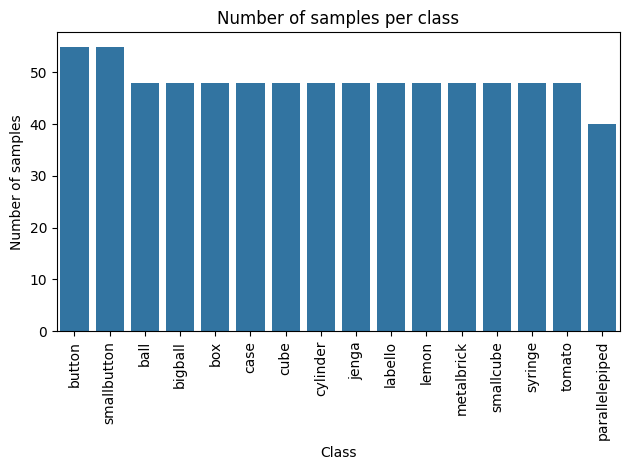

In [5]:
print("Number of samples:", X.shape[0])
print("Number of timesteps per sample:", X.shape[1])
print("Number of features per timestep:", X.shape[2])
print("Number of classes:", len(np.unique(y)))
class_counts = pd.Series(y).value_counts()
display(class_counts)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Number of samples per class')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.tight_layout()

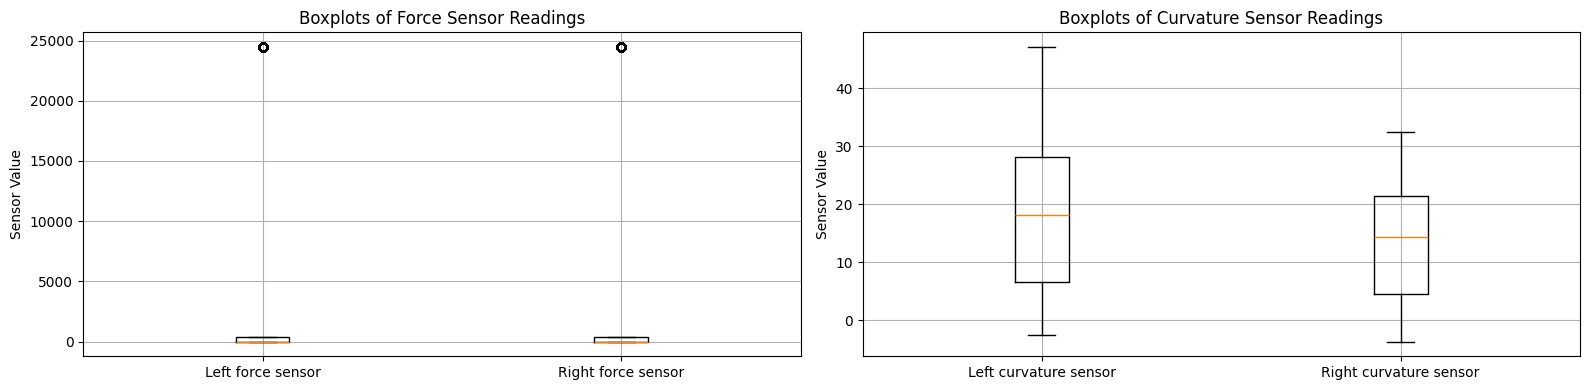

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].boxplot([X[:, :, 0].flatten(),  X[:, :, 1].flatten()], tick_labels=['Left force sensor', 'Right force sensor'])
axs[0].set_title('Boxplots of Force Sensor Readings')
axs[0].set_ylabel('Sensor Value')
axs[0].grid(True)

axs[1].boxplot([X[:, :, 2].flatten(),  X[:, :, 3].flatten()], tick_labels=['Left curvature sensor', 'Right curvature sensor'])
axs[1].set_title('Boxplots of Curvature Sensor Readings')
axs[1].set_ylabel('Sensor Value')
axs[1].grid(True)

plt.tight_layout()

In [7]:
def plot_random_samples(X, y, obj_ids, feature, num_objs_to_plot):
    if feature == 'fsr1':
        feature_idx = 0
        feature_name = 'Left force sensor'
    elif feature == 'fsr2':
        feature_idx = 1
        feature_name = 'Right force sensor'
    elif feature == 'cs1':
        feature_idx = 2
        feature_name = 'Left curvature sensor'
    elif feature == 'cs2':
        feature_idx = 3
        feature_name = 'Right curvature sensor'
    else:
        raise ValueError("Invalid feature specified. Choose from 'fsr1', 'fsr2', 'cs1', 'cs2'.")
    _, axs = plt.subplots(len(np.unique(y)), 1, figsize=(20, 3*len(np.unique(y))), sharey=True)
    colors = sns.color_palette("hls", num_objs_to_plot)
    for i, obj in enumerate(np.unique(y)):
        objs = np.where(y == obj)[0]
        objs_sub = np.random.choice(objs, size=num_objs_to_plot, replace=False)
        for j, obj_idx in enumerate(objs_sub):
            axs[i].plot(X[obj_idx, :, feature_idx], '-o', color=colors[j], markersize=4)
        axs[i].set_title(f'{feature_name} - {obj_ids[objs_sub[0]]}')
        axs[i].grid()
        axs[i].set_ylabel('Sensor Value')
        axs[i].set_xlabel('Time Steps')
    plt.tight_layout()

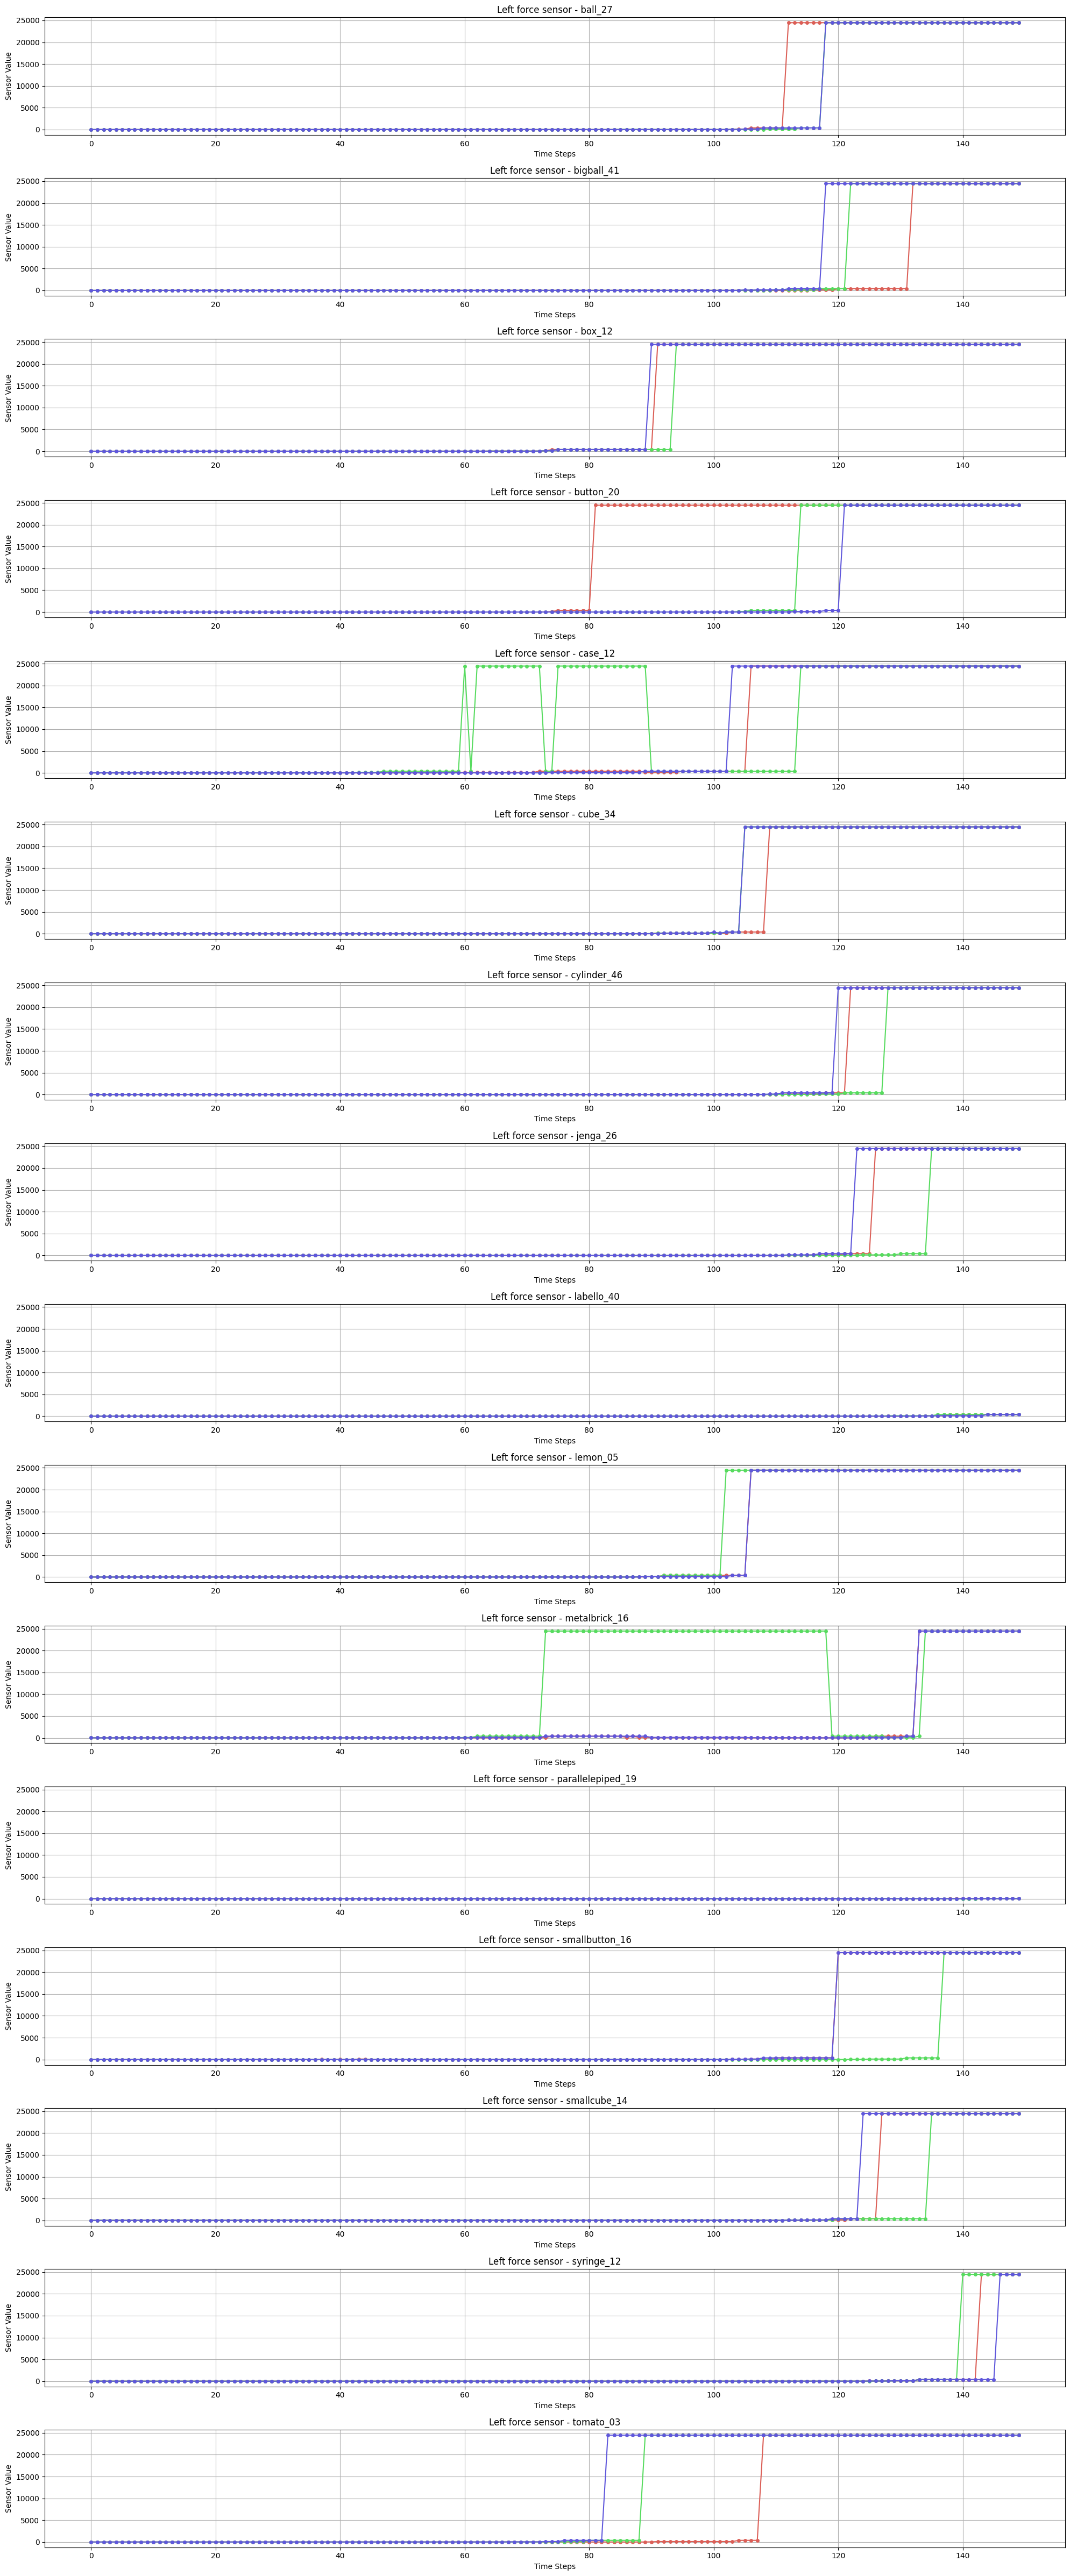

In [8]:
plot_random_samples(X, y, ids, feature='fsr1', num_objs_to_plot=3)

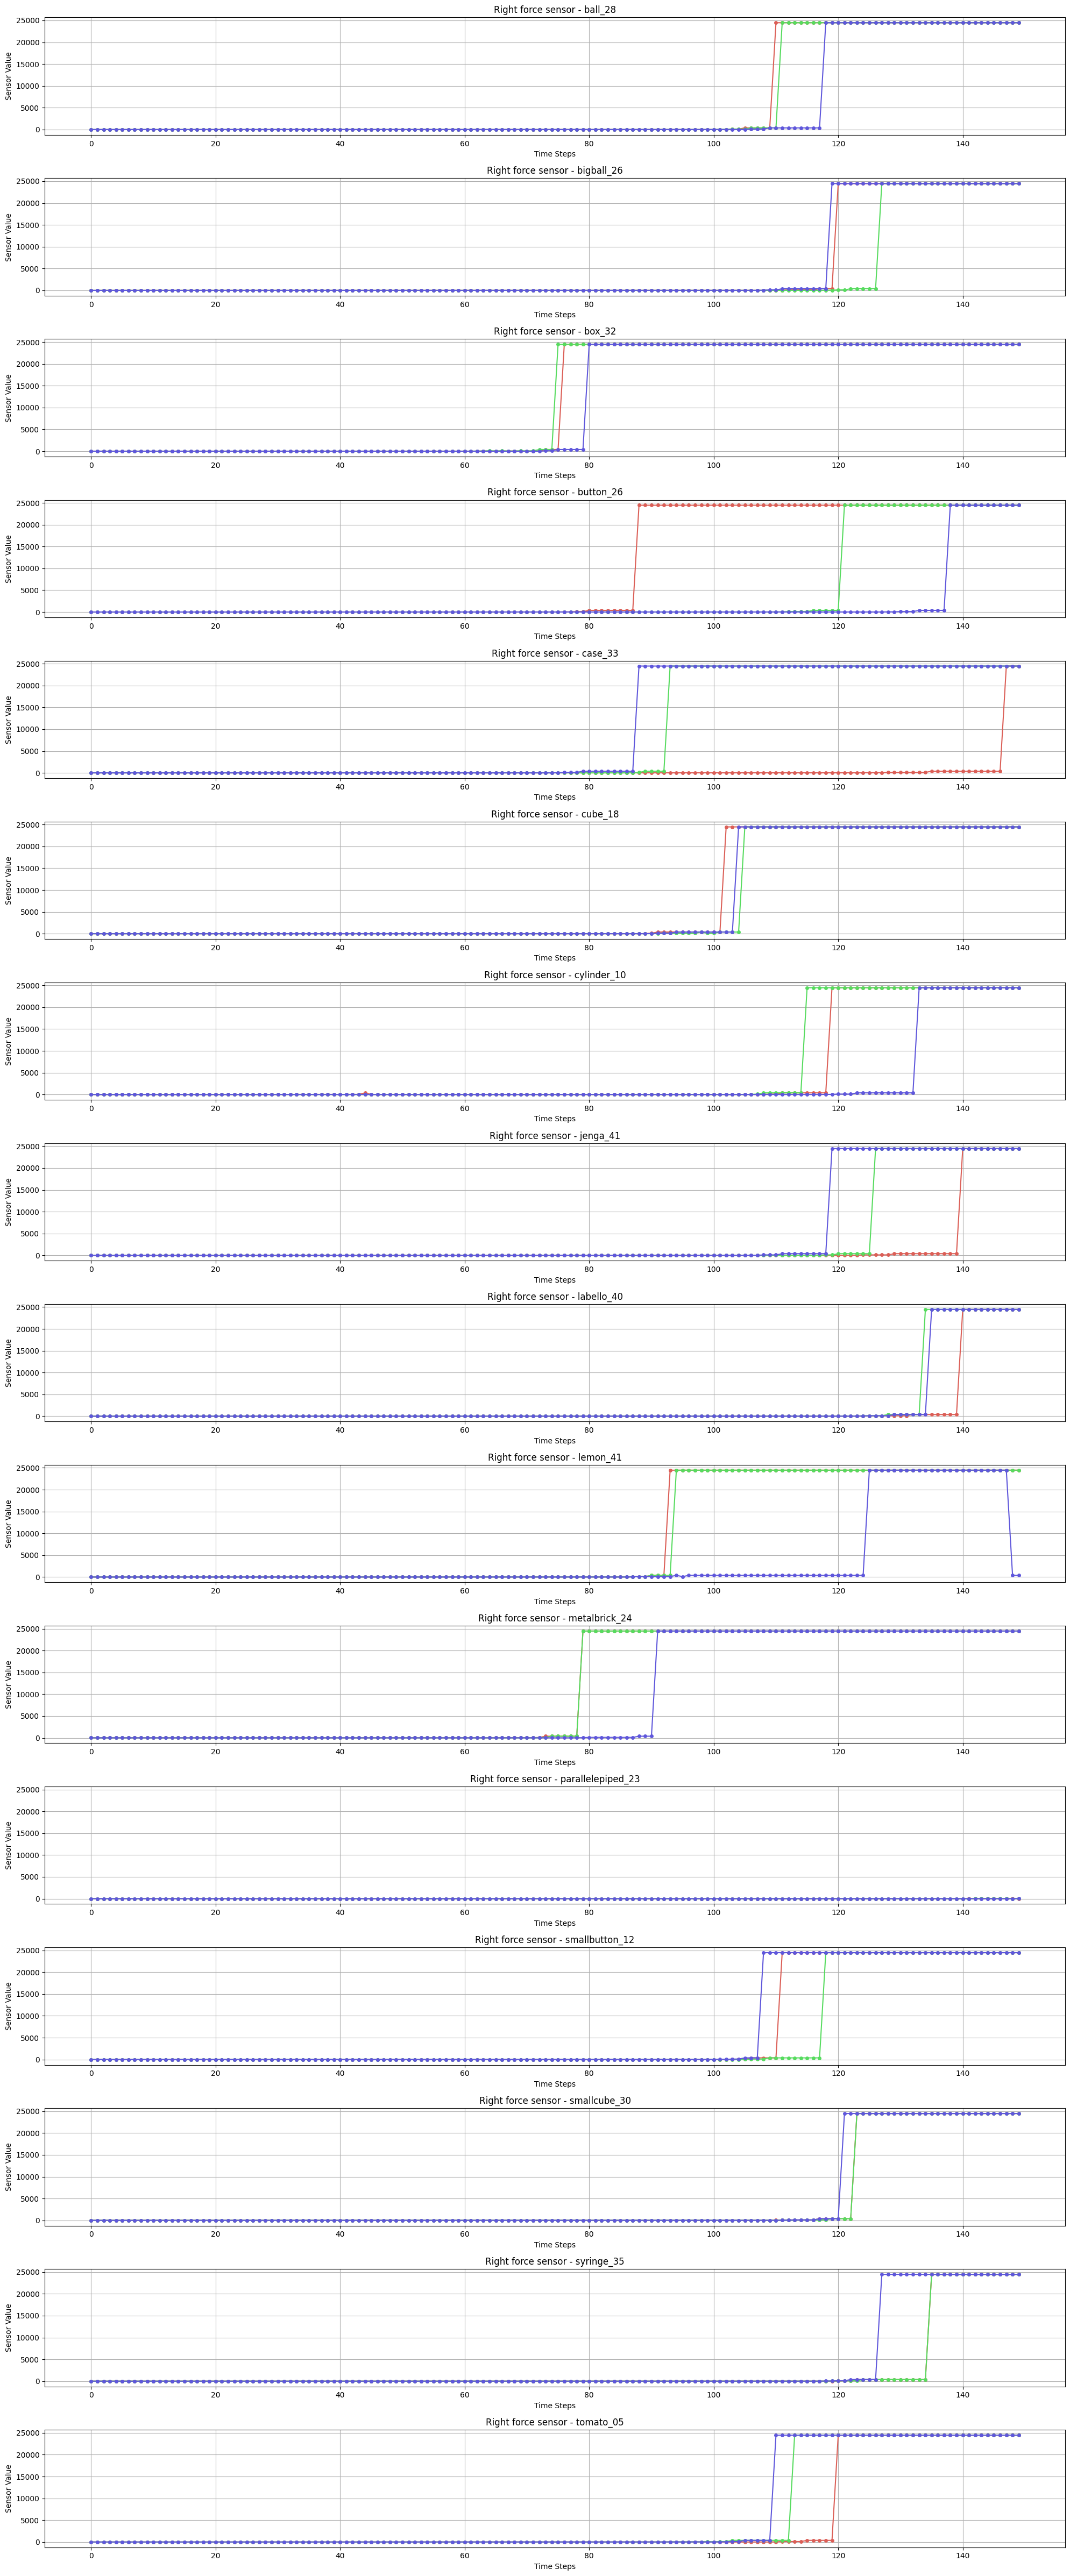

In [9]:
plot_random_samples(X, y, ids, feature='fsr2', num_objs_to_plot=3)

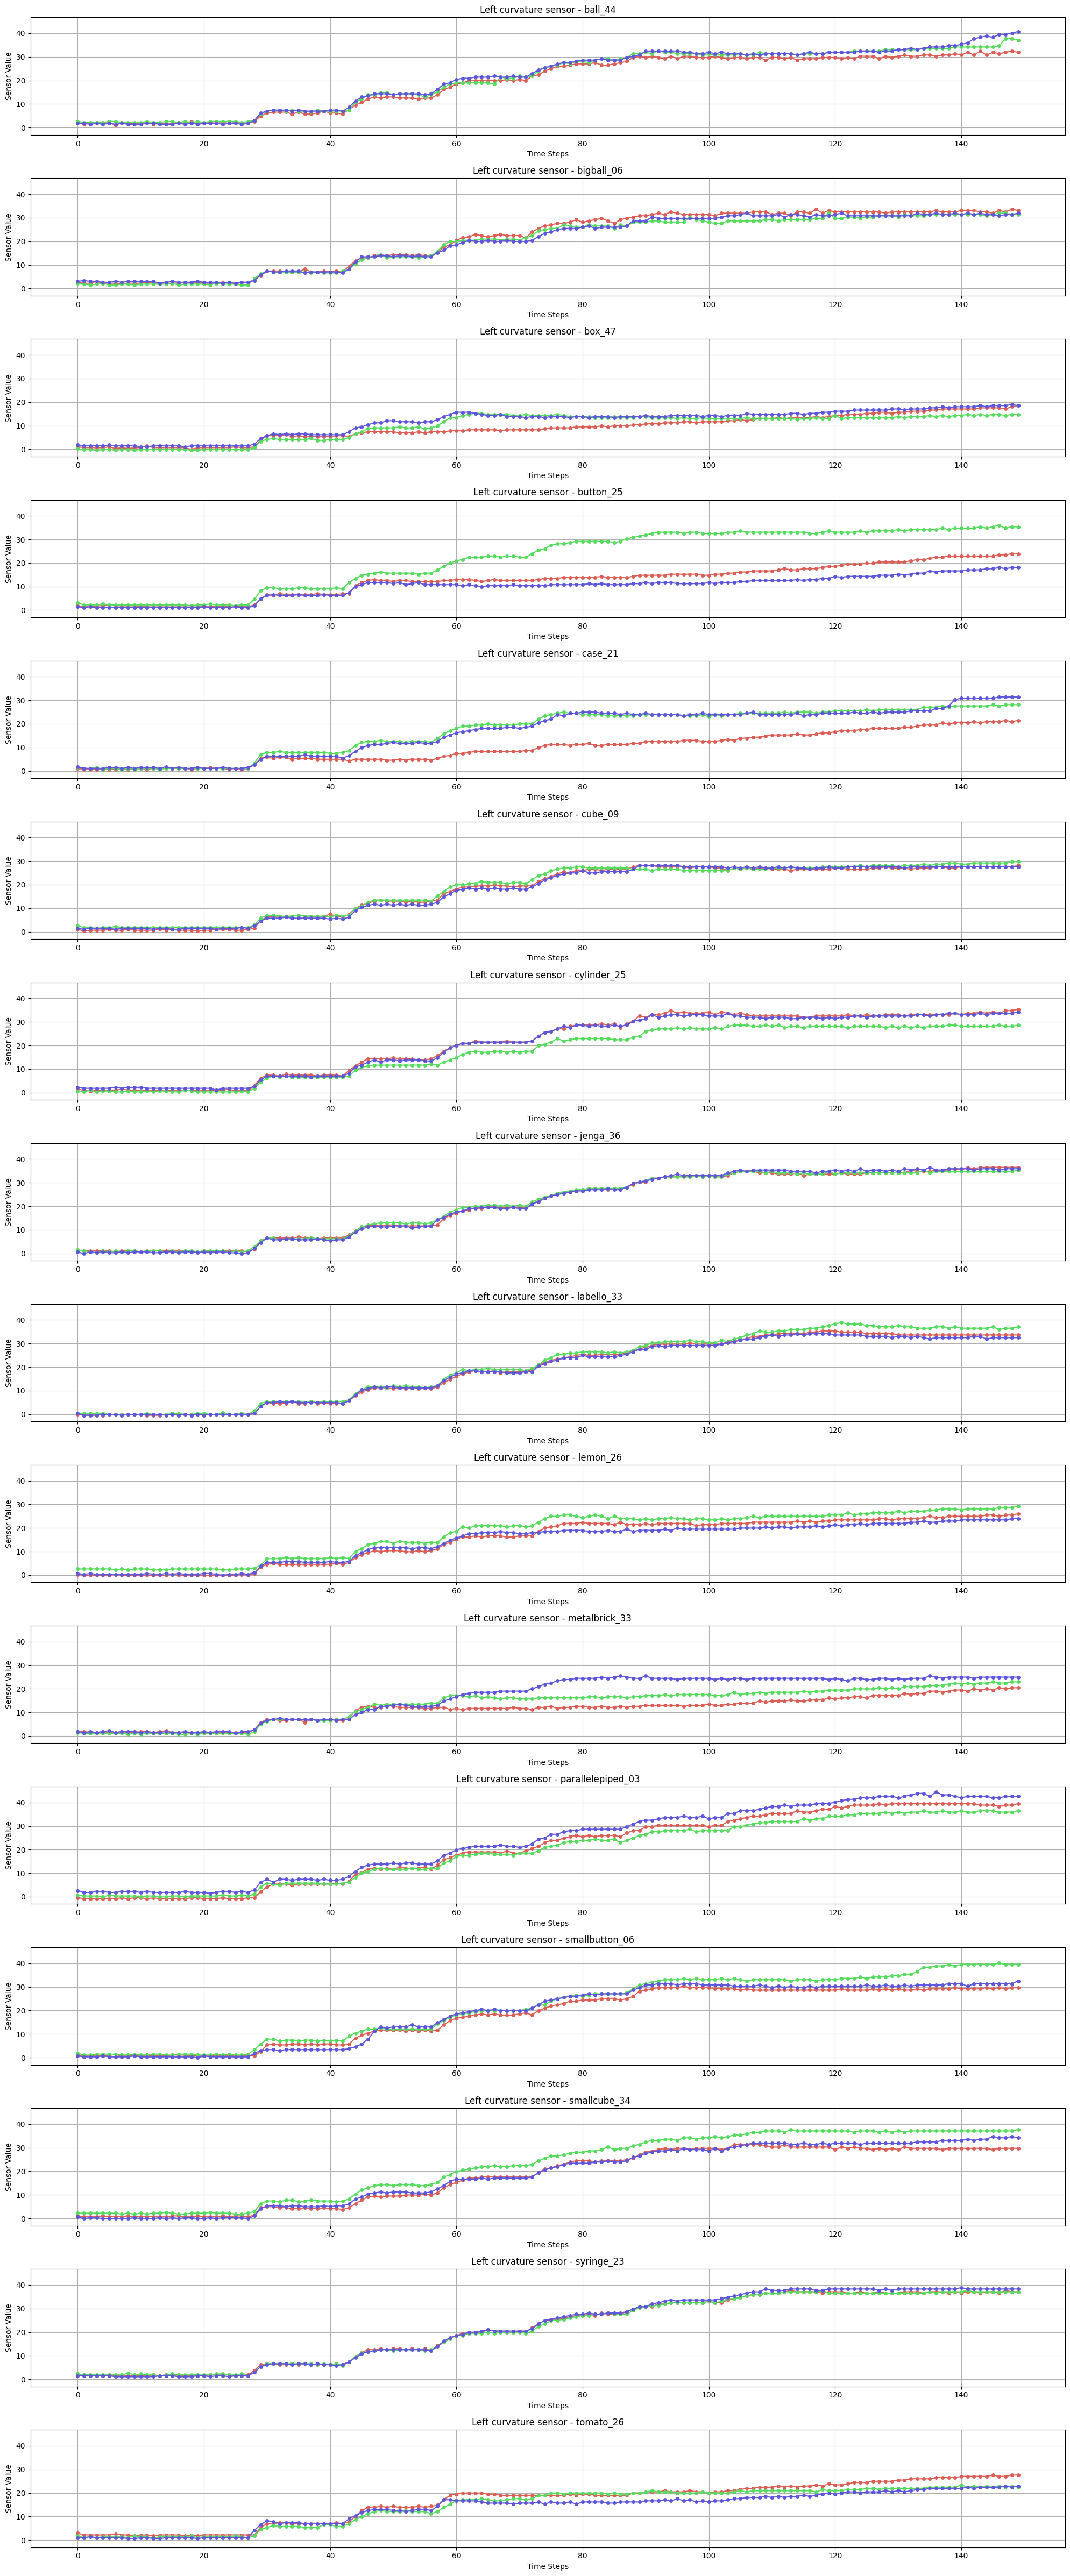

In [10]:
plot_random_samples(X, y, ids, feature='cs1', num_objs_to_plot=3)

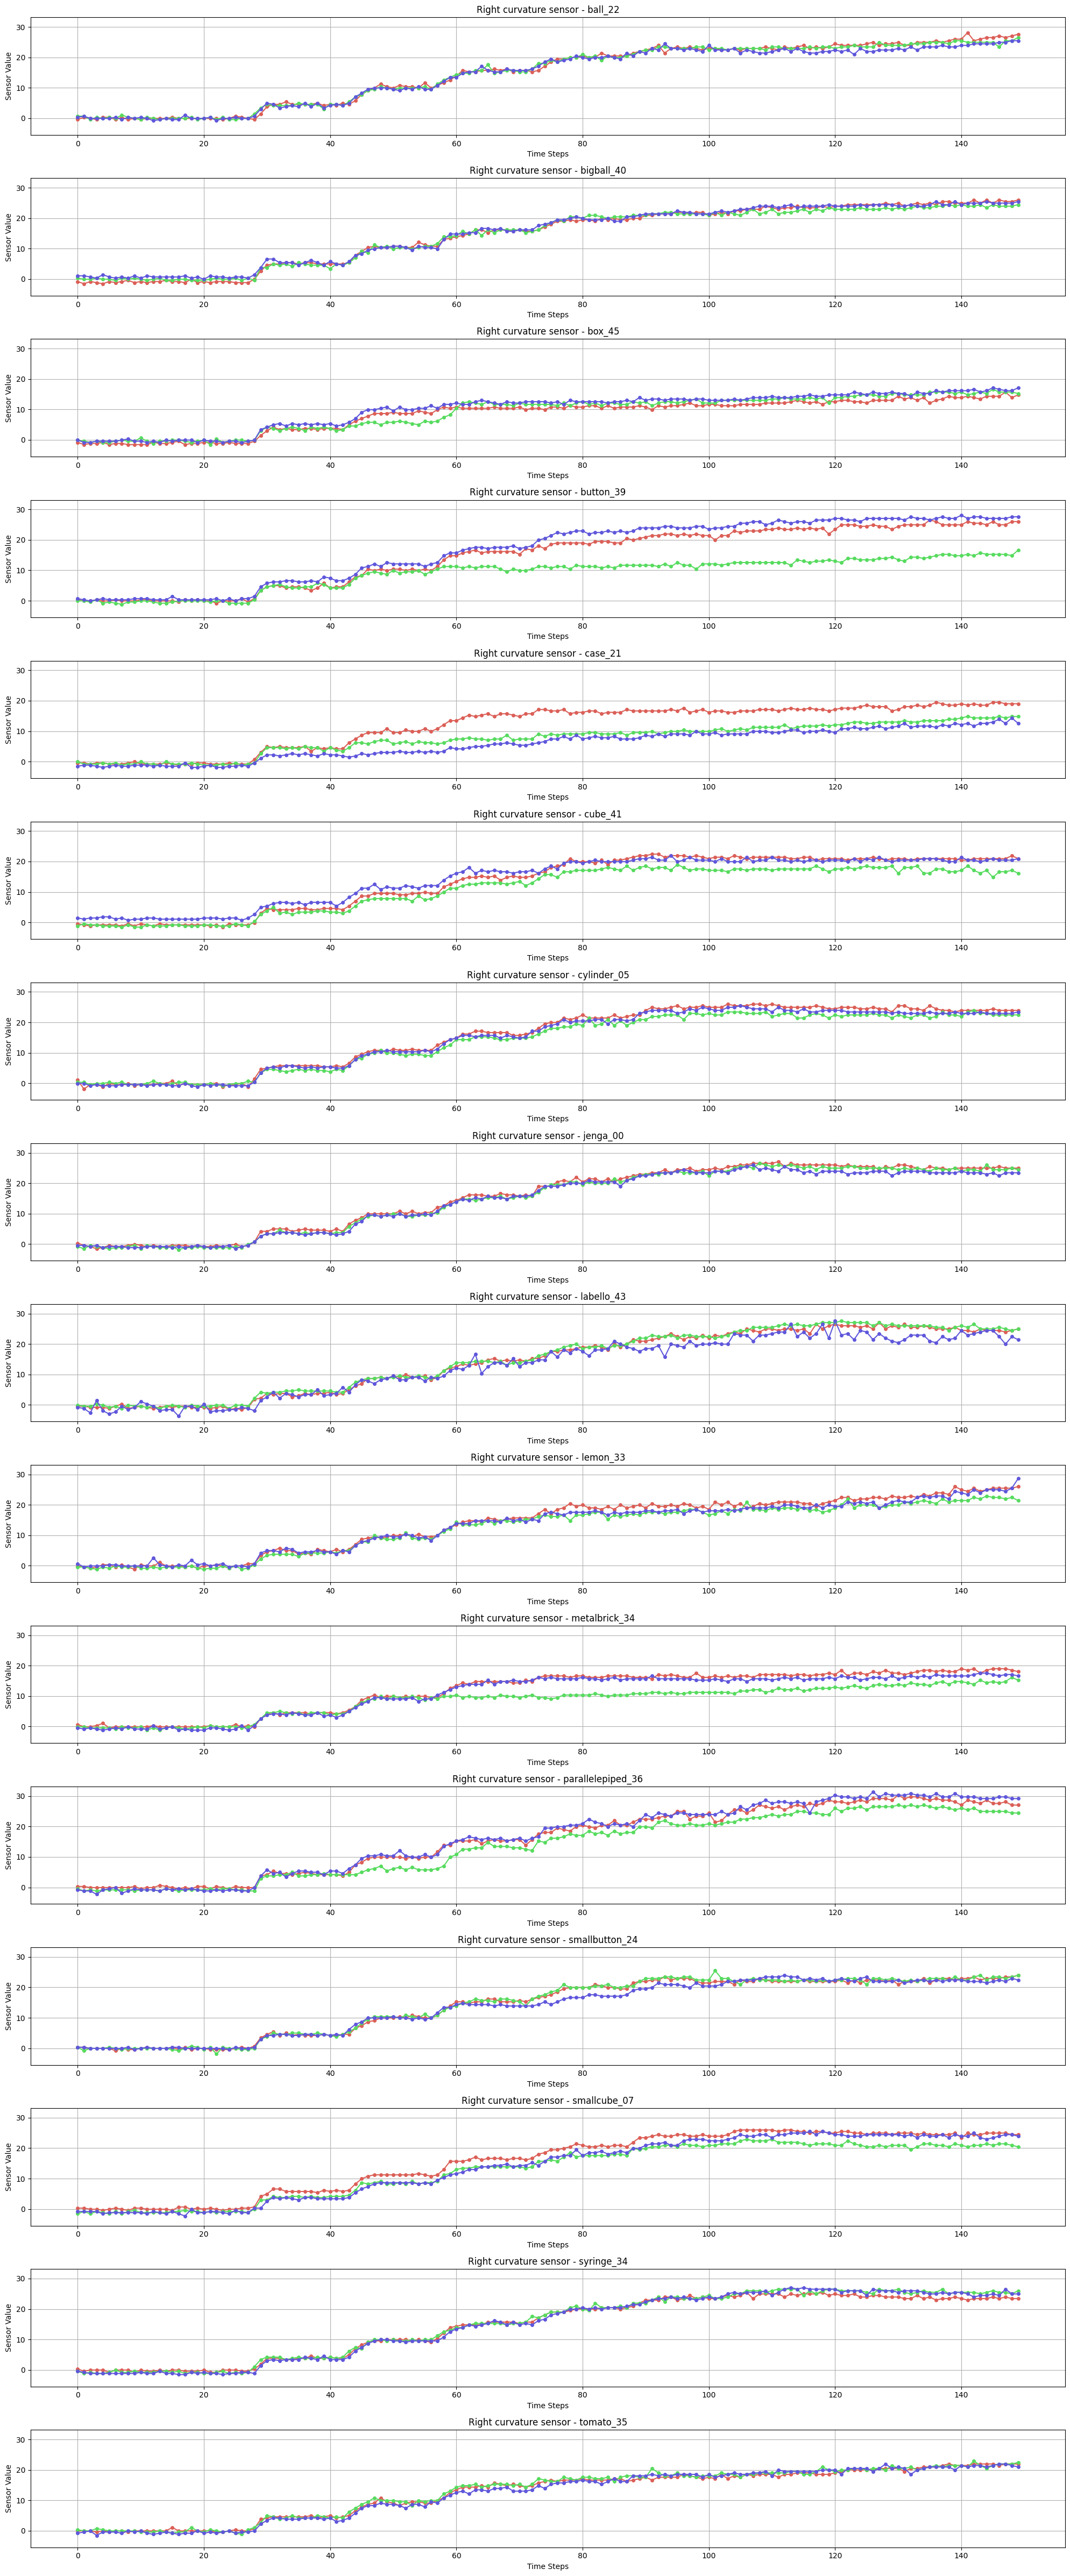

In [11]:
plot_random_samples(X, y, ids, feature='cs2', num_objs_to_plot=3)

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)
y_mapping = le.classes_
X_train, X_dev, y_train, y_dev, ids_train, ids_dev = train_test_split(
    X, y, ids, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_dev, y_dev, ids_dev, test_size=0.5, random_state=RANDOM_SEED, stratify=y_dev
)
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 619
Validation set size: 77
Test set size: 78


In [13]:
def scale_data(X_train, X_test, X_val=None):
    scaler = MinMaxScaler()

    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler.transform(X_test_reshaped)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)

    if X_val is not None:
        X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
        X_val_scaled = scaler.transform(X_val_reshaped)
        X_val_scaled = X_val_scaled.reshape(X_val.shape)
        return X_train_scaled, X_test_scaled, X_val_scaled

    return X_train_scaled, X_test_scaled

In [14]:
X_train, X_test, X_val = scale_data(X_train, X_test, X_val)

X_dev = np.concatenate([X_train, X_val], axis=0)
y_dev = np.concatenate([y_train, y_val], axis=0)

np.savez_compressed(
    os.path.join(DATASET_DIR, 'dataset.npz'),
    X_train=X_train, y_train=y_train, ids_train=ids_train,
    X_val=X_val, y_val=y_val, ids_val=ids_val,
    X_dev=X_dev, y_dev=y_dev, ids_dev=ids_dev,
    X_test=X_test, y_test=y_test, ids_test=ids_test,
    y_mapping=y_mapping
)

StandardScaler is preferred over MinMaxScaler because it is less sensitive to outliers, which are present in the dataset. 

StandardScaler is preferred over MinMaxScaler because it avoids compressing data into a narrow range, preserving feature variability especially with outliers, which are present in the dataset.

MinMaxScaler is preferred over StandardScaler because the data is not gaussianly distributed. <--

In [15]:
def create_base_dataset(X, y, ids, new_classes):
    is_new = np.isin(y, new_classes)
    is_base = ~is_new
    X_base, y_base, ids_base = X[is_base], y[is_base], ids[is_base]
    X_new,  y_new,  ids_new  = X[is_new],  y[is_new],  ids[is_new]

    X_train, X_dev, y_train, y_dev, ids_train, ids_dev = train_test_split(
        X_base, y_base, ids_base, test_size=0.2, random_state=RANDOM_SEED, stratify=y_base
    )
    X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
        X_dev, y_dev, ids_dev, test_size=0.5, random_state=RANDOM_SEED, stratify=y_dev
    )

    X_train_scaled, X_test_scaled, X_val_scaled = scale_data(X_train, X_test, X_val)
    _, X_new_scaled = scale_data(X_train, X_new)
    
    X_dev_scaled = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
    y_dev = np.concatenate([y_train, y_val], axis=0)

    return {
        'X_train': X_train_scaled, 'y_train': y_train, 'ids_train': ids_train,
        'X_val': X_val_scaled, 'y_val': y_val, 'ids_val': ids_val,
        'X_dev': X_dev_scaled, 'y_dev': y_dev, 'ids_dev': ids_dev,
        'X_test': X_test_scaled, 'y_test': y_test, 'ids_test': ids_test,
        'X_new': X_new_scaled, 'y_new': y_new, 'ids_new': ids_new,
    }


def create_few_shot_dataset(X, y, ids, num_shots):
    X_support, y_support, ids_support = [], [], []
    X_query, y_query, ids_query = [], [], []
    for cls in np.unique(y):
        cls_indices = np.where(y == cls)[0]
        if len(cls_indices) < num_shots + 1:
            raise ValueError(f"Not enough samples for class {cls} to create {num_shots} shots.")
        rng = np.random.default_rng(seed=RANDOM_SEED)
        support_indices = rng.choice(cls_indices, size=num_shots, replace=False)
        query_indices = np.setdiff1d(cls_indices, support_indices)

        X_support.append(X[support_indices])
        y_support.append(y[support_indices])
        ids_support.append(ids[support_indices])

        X_query.append(X[query_indices])
        y_query.append(y[query_indices])
        ids_query.append(ids[query_indices])
        
    X_support = np.concatenate(X_support, axis=0)
    y_support = np.concatenate(y_support, axis=0)
    ids_support = np.concatenate(ids_support, axis=0)
    X_query = np.concatenate(X_query, axis=0)
    y_query = np.concatenate(y_query, axis=0)
    ids_query = np.concatenate(ids_query, axis=0)

    return {
        'X_support': X_support, 'y_support': y_support, 'ids_support': ids_support,
        'X_query': X_query, 'y_query': y_query, 'ids_query': ids_query
    }


In [16]:
easy_classes = le.transform(['cube', 'parallelepiped', 'syringe', 'tomato'])

easy_base_dataset = create_base_dataset(X, y, ids, easy_classes)
np.savez_compressed(
    os.path.join(DATASET_DIR, 'base_dataset_easy.npz'),
    X_train=easy_base_dataset["X_train"], y_train=easy_base_dataset["y_train"], ids_train=easy_base_dataset["ids_train"],
    X_val=easy_base_dataset["X_val"], y_val=easy_base_dataset["y_val"], ids_val=easy_base_dataset["ids_val"],
    X_dev=easy_base_dataset["X_dev"], y_dev=easy_base_dataset["y_dev"], ids_dev=easy_base_dataset["ids_dev"],
    X_test=easy_base_dataset["X_test"], y_test=easy_base_dataset["y_test"], ids_test=easy_base_dataset["ids_test"],
    y_mapping=y_mapping
)

easy_5_shot_dataset = create_few_shot_dataset(easy_base_dataset["X_new"], easy_base_dataset["y_new"], easy_base_dataset["ids_new"], num_shots=5)
np.savez_compressed(
    os.path.join(DATASET_DIR, '5shot_dataset_easy.npz'),
    X_support=easy_5_shot_dataset["X_support"], y_support=easy_5_shot_dataset["y_support"], ids_support=easy_5_shot_dataset["ids_support"],
    X_query=easy_5_shot_dataset["X_query"], y_query=easy_5_shot_dataset["y_query"], ids_query=easy_5_shot_dataset["ids_query"],
    y_mapping=y_mapping
)

easy_10_shot_dataset = create_few_shot_dataset(easy_base_dataset["X_new"], easy_base_dataset["y_new"], easy_base_dataset["ids_new"], num_shots=10)
np.savez_compressed(
    os.path.join(DATASET_DIR, '10shot_dataset_easy.npz'),
    X_support=easy_10_shot_dataset["X_support"], y_support=easy_10_shot_dataset["y_support"], ids_support=easy_10_shot_dataset["ids_support"],
    X_query=easy_10_shot_dataset["X_query"], y_query=easy_10_shot_dataset["y_query"], ids_query=easy_10_shot_dataset["ids_query"],
    y_mapping=y_mapping
)

In [17]:
random_classes = np.arange(5)

random_base_dataset = create_base_dataset(X, y, ids, random_classes)
np.savez_compressed(
    os.path.join(DATASET_DIR, 'base_dataset_random.npz'),
    X_train=random_base_dataset["X_train"], y_train=random_base_dataset["y_train"], ids_train=random_base_dataset["ids_train"],
    X_val=random_base_dataset["X_val"], y_val=random_base_dataset["y_val"], ids_val=random_base_dataset["ids_val"],
    X_dev=random_base_dataset["X_dev"], y_dev=random_base_dataset["y_dev"], ids_dev=random_base_dataset["ids_dev"],
    X_test=random_base_dataset["X_test"], y_test=random_base_dataset["y_test"], ids_test=random_base_dataset["ids_test"],
    y_mapping=y_mapping
)

random_5_shot_dataset = create_few_shot_dataset(random_base_dataset["X_new"], random_base_dataset["y_new"], random_base_dataset["ids_new"], num_shots=5)
np.savez_compressed(
    os.path.join(DATASET_DIR, '5shot_dataset_random.npz'),
    X_support=random_5_shot_dataset["X_support"], y_support=random_5_shot_dataset["y_support"], ids_support=random_5_shot_dataset["ids_support"],
    X_query=random_5_shot_dataset["X_query"], y_query=random_5_shot_dataset["y_query"], ids_query=random_5_shot_dataset["ids_query"],
    y_mapping=y_mapping
)

random_10_shot_dataset = create_few_shot_dataset(random_base_dataset["X_new"], random_base_dataset["y_new"], random_base_dataset["ids_new"], num_shots=10)
np.savez_compressed(
    os.path.join(DATASET_DIR, '10shot_dataset_random.npz'),
    X_support=random_10_shot_dataset["X_support"], y_support=random_10_shot_dataset["y_support"], ids_support=random_10_shot_dataset["ids_support"],
    X_query=random_10_shot_dataset["X_query"], y_query=random_10_shot_dataset["y_query"], ids_query=random_10_shot_dataset["ids_query"],
    y_mapping=y_mapping
)

In [ ]:
base_data = np.load('./dataset/base_dataset_easy.npz')
X_train = base_data['X_train']
y_train = base_data['y_train']
X_val = base_data['X_val']
y_val = base_data['y_val']
X_test = base_data['X_test']
y_test = base_data['y_test']
y_mapping = base_data['y_mapping']

few_show_data = np.load('./dataset/5shot_dataset_easy.npz')
X_support = few_show_data['X_support']
y_support = few_show_data['y_support']
X_query = few_show_data['X_query']
y_query = few_show_data['y_query']